In [1]:
import scipy.io
import random
import torch
import numpy as np
from torch import nn
import matplotlib.pylab as plt
class MLP(nn.Module):

    def __init__(self, nInput, nOutput):
        super(MLP, self).__init__()

        # two hidden layers
        self.layers = nn.Sequential(
            nn.Linear(nInput, 40),
            nn.ReLU(),
            nn.Linear(40, 60),
            nn.ReLU(),
            nn.Linear(60, nOutput)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# from google.colab import drive
# drive.mount('/content/drive/')

nInput = 2
nOutput = 2+2+2
model_a = MLP(nInput, nOutput)
model_b = MLP(nInput, nOutput)
model_a.load_state_dict(torch.load('model_a_1520.pt'))
model_b.load_state_dict(torch.load('model_b_1520.pt'))

train_data_a = scipy.io.loadmat('data_a_2_1520.mat')
a_train_db = torch.tensor(train_data_a['db'])
a_train_ctrl = torch.tensor(train_data_a['ctrl'])
a_means = torch.tensor(train_data_a['means'])
train_data_b = scipy.io.loadmat('data_b_2_1520.mat')
b_train_da = torch.tensor(train_data_b['da'])
b_train_ctrl = torch.tensor(train_data_b['ctrl'])
b_means = torch.tensor(train_data_b['means'])

FREQS = torch.tensor(train_data_b['freqs'])
MEAN_SPEED = torch.tensor(train_data_b['speeds'])

C:\Users\Das_Lab_Admin\AppData\Local\Temp\ipykernel_8872\126694073.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_a.load_state_dict(torch.load('model_a_1520.pt')

In [5]:
# @title Interp1d
import torch
import contextlib

class Interp1d(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y, xnew, out=None):
        """
        Linear 1D interpolation on the GPU for Pytorch.
        This function returns interpolated values of a set of 1-D functions at
        the desired query points `xnew`.
        This function is working similarly to Matlab™ or scipy functions with
        the `linear` interpolation mode on, except that it parallelises over
        any number of desired interpolation problems.
        The code will run on GPU if all the tensors provided are on a cuda
        device.

        Parameters
        ----------
        x : (N, ) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values.
        y : (N,) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values. The length of `y` along its
            last dimension must be the same as that of `x`
        xnew : (P,) or (D, P) Pytorch Tensor
            A 1-D or 2-D tensor of real values. `xnew` can only be 1-D if
            _both_ `x` and `y` are 1-D. Otherwise, its length along the first
            dimension must be the same as that of whichever `x` and `y` is 2-D.
        out : Pytorch Tensor, same shape as `xnew`
            Tensor for the output. If None: allocated automatically.

        """
        # making the vectors at least 2D
        is_flat = {}
        require_grad = {}
        v = {}
        device = []
        eps = torch.finfo(y.dtype).eps
        for name, vec in {'x': x, 'y': y, 'xnew': xnew}.items():
            assert len(vec.shape) <= 2, 'interp1d: all inputs must be '\
                                        'at most 2-D.'
            if len(vec.shape) == 1:
                v[name] = vec[None, :]
            else:
                v[name] = vec
            is_flat[name] = v[name].shape[0] == 1
            require_grad[name] = vec.requires_grad
            device = list(set(device + [str(vec.device)]))
        assert len(device) == 1, 'All parameters must be on the same device.'
        device = device[0]

        # Checking for the dimensions
        assert (v['x'].shape[1] == v['y'].shape[1]
                and (
                     v['x'].shape[0] == v['y'].shape[0]
                     or v['x'].shape[0] == 1
                     or v['y'].shape[0] == 1
                    )
                ), ("x and y must have the same number of columns, and either "
                    "the same number of row or one of them having only one "
                    "row.")

        reshaped_xnew = False
        if ((v['x'].shape[0] == 1) and (v['y'].shape[0] == 1)
           and (v['xnew'].shape[0] > 1)):
            # if there is only one row for both x and y, there is no need to
            # loop over the rows of xnew because they will all have to face the
            # same interpolation problem. We should just stack them together to
            # call interp1d and put them back in place afterwards.
            original_xnew_shape = v['xnew'].shape
            v['xnew'] = v['xnew'].contiguous().view(1, -1)
            reshaped_xnew = True

        # identify the dimensions of output and check if the one provided is ok
        D = max(v['x'].shape[0], v['xnew'].shape[0])
        shape_ynew = (D, v['xnew'].shape[-1])
        if out is not None:
            if out.numel() != shape_ynew[0]*shape_ynew[1]:
                # The output provided is of incorrect shape.
                # Going for a new one
                out = None
            else:
                ynew = out.reshape(shape_ynew)
        if out is None:
            ynew = torch.zeros(*shape_ynew, device=device)

        # moving everything to the desired device in case it was not there
        # already (not handling the case things do not fit entirely, user will
        # do it if required.)
        for name in v:
            v[name] = v[name].to(device)

        # calling searchsorted on the x values.
        ind = ynew.long()

        # expanding xnew to match the number of rows of x in case only one xnew is
        # provided
        if v['xnew'].shape[0] == 1:
            v['xnew'] = v['xnew'].expand(v['x'].shape[0], -1)

        # the squeeze is because torch.searchsorted does accept either a nd with
        # matching shapes for x and xnew or a 1d vector for x. Here we would
        # have (1,len) for x sometimes
        torch.searchsorted(v['x'].contiguous().squeeze(),
                           v['xnew'].contiguous(), out=ind)

        # the `-1` is because searchsorted looks for the index where the values
        # must be inserted to preserve order. And we want the index of the
        # preceeding value.
        ind -= 1
        # we clamp the index, because the number of intervals is x.shape-1,
        # and the left neighbour should hence be at most number of intervals
        # -1, i.e. number of columns in x -2
        ind = torch.clamp(ind, 0, v['x'].shape[1] - 1 - 1)

        # helper function to select stuff according to the found indices.
        def sel(name):
            if is_flat[name]:
                return v[name].contiguous().view(-1)[ind]
            return torch.gather(v[name], 1, ind)

        # activating gradient storing for everything now
        enable_grad = False
        saved_inputs = []
        for name in ['x', 'y', 'xnew']:
            if require_grad[name]:
                enable_grad = True
                saved_inputs += [v[name]]
            else:
                saved_inputs += [None, ]
        # assuming x are sorted in the dimension 1, computing the slopes for
        # the segments
        is_flat['slopes'] = is_flat['x']
        # now we have found the indices of the neighbors, we start building the
        # output. Hence, we start also activating gradient tracking
        with torch.enable_grad() if enable_grad else contextlib.suppress():
            v['slopes'] = (
                    (v['y'][:, 1:]-v['y'][:, :-1])
                    /
                    (eps + (v['x'][:, 1:]-v['x'][:, :-1]))
                )

            # now build the linear interpolation
            ynew = sel('y') + sel('slopes')*(
                                    v['xnew'] - sel('x'))

            if reshaped_xnew:
                ynew = ynew.view(original_xnew_shape)

        ctx.save_for_backward(ynew, *saved_inputs)
        return ynew

    @staticmethod
    def backward(ctx, grad_out):
        inputs = ctx.saved_tensors[1:]
        gradients = torch.autograd.grad(
                        ctx.saved_tensors[0],
                        [i for i in inputs if i is not None],
                        grad_out, retain_graph=True)
        result = [None, ] * 5
        pos = 0
        for index in range(len(inputs)):
            if inputs[index] is not None:
                result[index] = gradients[pos]
                pos += 1
        return (*result,)


interp1d = Interp1d.apply

In [6]:
def getControl(da, db):
    mag_a = torch.sqrt(torch.dot(da,da))
    mag_b = torch.sqrt(torch.dot(db,db))
    if mag_a > mag_b:
        angle = torch.arctan2(da[1], da[0]) - torch.pi/2;
        A = torch.tensor([[torch.cos(-angle), -torch.sin(-angle)], [torch.sin(-angle), torch.cos(-angle)]]) / mag_a
        db = A @ db

        reflect = False
        if db[0] < 0:
            db[0] = -db[0]
            reflect = True

        ctrl = model_a(db.float()).double() + a_means
        if reflect:
            ctrl[:,2:4] = torch.arctan2(torch.sin(ctrl[:,2:4]), -torch.cos(ctrl[:,2:4]))

        ctrl[:,2:4] += angle
        ctrl[:,4:6] *= mag_a

        return ctrl
    else:
        angle = torch.arctan2(db[1], db[0]) - torch.pi/2;
        A = torch.tensor([[torch.cos(-angle), -torch.sin(-angle)], [torch.sin(-angle), torch.cos(-angle)]]) / mag_b
        da = A @ da

        reflect = False
        if da[0] < 0:
            da[0] = -da[0]
            reflect = True


        ctrl = model_b(da.float()).double() + b_means

        if reflect:
            ctrl[:,2:4] = torch.arctan2(torch.sin(ctrl[:,2:4]), -torch.cos(ctrl[:,2:4]))

        ctrl[:,2:4] += angle
        ctrl[:,4:6] *= mag_b

        return ctrl

In [7]:
# test getControl
da = torch.tensor([.45, 1.2])
db = torch.tensor([-0.7, 0.6])
print(da)
print(db)
ctrl = getControl(da, db)
print(ctrl)

speeds_a = interp1d(FREQS, MEAN_SPEED[0,:], torch.round(ctrl[:,0:2])).squeeze()
speeds_b = interp1d(FREQS, MEAN_SPEED[1,:], torch.round(ctrl[:,0:2])).squeeze()
angles = ctrl[:,2:4].squeeze()
deltaTimes = ctrl[:,4:6].squeeze()

delta_a = torch.zeros(2)
delta_b = torch.zeros(2)
delta_a[0] = torch.sum(speeds_a * torch.cos(angles) * deltaTimes) #x
delta_a[1] = torch.sum(speeds_a * torch.sin(angles) * deltaTimes) #y
delta_b[0] = torch.sum(speeds_b * torch.cos(angles) * deltaTimes) #x
delta_b[1] = torch.sum(speeds_b * torch.sin(angles) * deltaTimes) #y

print(delta_a)
print(delta_b)

tensor([0.4500, 1.2000])
tensor([-0.7000,  0.6000])
tensor([[14.9934, 20.0005,  1.1257, -2.0115,  7.8709,  5.9844]],
       dtype=torch.float64, grad_fn=<CopySlices>)
tensor([1.8112, 2.3523], grad_fn=<CopySlices>)
tensor([9.2289, 8.9059], grad_fn=<CopySlices>)


In [8]:
#test using a single training sample
def genData_opt(nSample = 1):
    if(nSample == 0):
        return

    if torch.rand(1) > 0.5:
        unique_rows = random.sample(range(b_train_da.shape[0]), nSample)
        train_da_sample = b_train_da[unique_rows, :].squeeze()
        train_db_sample = torch.tensor([0,1], dtype=torch.float64)
        train_ctrl_sample = b_train_ctrl[unique_rows, :].squeeze() + b_means
    else:
        unique_rows = random.sample(range(a_train_db.shape[0]), nSample)
        train_da_sample = torch.tensor([0,1], dtype=torch.float64)
        train_db_sample = a_train_db[unique_rows, :].squeeze()
        train_ctrl_sample = a_train_ctrl[unique_rows, :].squeeze() + a_means

    return train_da_sample, train_db_sample, train_ctrl_sample

In [9]:
da_train, db_train, ctrl_train = genData_opt()
print(da_train)
print(db_train)
ctrl = getControl(da_train, db_train)

print(ctrl_train)
print(ctrl)

tensor([ 0.8965, -0.2143], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([[15.0000, 20.0000, -0.3747,  2.7657,  6.1092,  4.7015]],
       dtype=torch.float64)
tensor([[15.0002, 19.9964, -0.3769,  2.7567,  6.1048,  4.6942]],
       dtype=torch.float64, grad_fn=<CopySlices>)


tensor([-33.8113,  11.3712])
tensor([15.9243,  9.6778])
tensor([[ 15.0099,  19.9863,   2.8721,  -0.2564, 234.3962, 181.9919]],
       dtype=torch.float64, grad_fn=<CopySlices>)


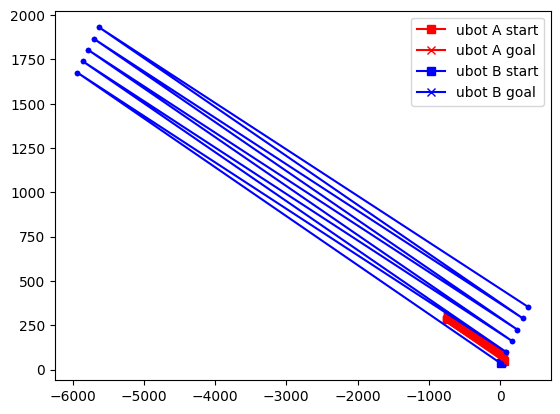

tensor([17.5523, 53.9051], grad_fn=<CopySlices>)
tensor([384.4048, 318.5010], grad_fn=<CopySlices>)


In [11]:
#test with a random da and db

#limits for robot position
XMIN = 10
XMAX = 60
YMIN = 20
YMAX = 70

a0 = torch.tensor([(XMAX-XMIN)*np.random.rand() + XMIN, (YMAX-YMIN)*np.random.rand() + YMIN])
a1 = torch.tensor([(XMAX-XMIN)*np.random.rand() + XMIN, (YMAX-YMIN)*np.random.rand() + YMIN])
b0 = torch.tensor([(XMAX-XMIN)*np.random.rand() + XMIN, (YMAX-YMIN)*np.random.rand() + YMIN])
b1 = torch.tensor([(XMAX-XMIN)*np.random.rand() + XMIN, (YMAX-YMIN)*np.random.rand() + YMIN])

start_a, = plt.plot(a0[0].detach().numpy(), a0[1].detach().numpy(), color = 'r', marker = 's', label = 'ubot A start')
goal_a, = plt.plot(a1[0].detach().numpy(), a1[1].detach().numpy(), color = 'r', marker = 'x', label = 'ubot A goal')
start_b, = plt.plot(b0[0].detach().numpy(), b0[1].detach().numpy(), color = 'b', marker = 's', label = 'ubot B start')
goal_b, = plt.plot(b1[0].detach().numpy(), b1[1].detach().numpy(), color = 'b', marker = 'x', label = 'ubot B goal')

da = a1 - a0
db = b1 - b0
print(da)
print(db)

ctrl = getControl(da,db)
print(ctrl)

speeds_a = interp1d(FREQS, MEAN_SPEED[0,:], torch.round(ctrl[:,0:2])).squeeze()
speeds_b = interp1d(FREQS, MEAN_SPEED[1,:], torch.round(ctrl[:,0:2])).squeeze()
angles = ctrl[:,2:4]
deltaTimes = ctrl[:,4:6]

delta_a = torch.zeros(2)
delta_b = torch.zeros(2)

delta_a[0] = torch.sum(speeds_a * torch.cos(angles) * deltaTimes) #x
delta_a[1] = torch.sum(speeds_a * torch.sin(angles) * deltaTimes) #y
delta_b[0] = torch.sum(speeds_b * torch.cos(angles) * deltaTimes) #x
delta_b[1] = torch.sum(speeds_b * torch.sin(angles) * deltaTimes) #y

numSteps = 5
deltaTimes = deltaTimes / numSteps
pos_a = np.zeros((2,2*numSteps+1))
pos_b = np.zeros((2,2*numSteps+1))
pos_a[:,0] = a0
pos_b[:,0] = b0
for i in range(1,numSteps+1):
    pos_a[0,2*i-1] = pos_a[0,2*i-2] + speeds_a[0] * torch.cos(angles[0,0]) * deltaTimes[0,0] #x
    pos_a[1,2*i-1] = pos_a[1,2*i-2] + speeds_a[0] * torch.sin(angles[0,0]) * deltaTimes[0,0] #y
    pos_b[0,2*i-1] = pos_b[0,2*i-2] + speeds_b[0] * torch.cos(angles[0,0]) * deltaTimes[0,0] #x
    pos_b[1,2*i-1] = pos_b[1,2*i-2] + speeds_b[0] * torch.sin(angles[0,0]) * deltaTimes[0,0] #y

    pos_a[0,2*i] = pos_a[0,2*i-1] + speeds_a[1] * torch.cos(angles[0,1]) * deltaTimes[0,1] #x
    pos_a[1,2*i] = pos_a[1,2*i-1] + speeds_a[1] * torch.sin(angles[0,1]) * deltaTimes[0,1] #y
    pos_b[0,2*i] = pos_b[0,2*i-1] + speeds_b[1] * torch.cos(angles[0,1]) * deltaTimes[0,1] #x
    pos_b[1,2*i] = pos_b[1,2*i-1] + speeds_b[1] * torch.sin(angles[0,1]) * deltaTimes[0,1] #y

plt.scatter(pos_a[0,:], pos_a[1,:], color = 'r', marker = '.')
plt.scatter(pos_b[0,:], pos_b[1,:], color = 'b', marker = '.')
traj1, = plt.plot(pos_a[0,:], pos_a[1,:], color = 'r', marker = '.', label = 'ubot A')
traj2, = plt.plot(pos_b[0,:], pos_b[1,:], color = 'b', marker = '.', label = 'ubot B')

plt.legend(handles=[start_a, goal_a, start_b, goal_b])
plt.show()
print(delta_a)
print(delta_b)

In [10]:
print(pos_a)

[[30.28713799 22.5057699  29.86690929 22.08554121 29.4466806  21.66531252
  29.02645191 21.24508383 28.60622322 20.82485514 28.18599453]
 [48.13459778 41.25214665 47.40283357 40.52038245 46.67106936 39.78861824
  45.93930516 39.05685403 45.20754095 38.32508983 44.47577674]]


In [11]:
import copy
import time
import matplotlib.pyplot as plt
#from scipy.interpolate import interp1d

NUMBER_OF_AGENTS = 2

#limits for robot position
XMIN = 10
XMAX = 60
YMIN = 20
YMAX = 70

def simulate(xi = None,xf = None, animate_flag = True):
    '''
    xi: 2Xn list for the  initail confguration of N robots
    xf: 2Xn list for the final confguration of N robots
    '''
    # Just for testing:
    init_current_positions = [XMAX-XMIN, YMAX-YMIN]*np.random.rand(NUMBER_OF_AGENTS,2) + [XMIN, YMIN]
    init_current_positions = np.reshape(init_current_positions, [-1, 2*NUMBER_OF_AGENTS])
    #^^^^^^^^^^^^^^^^^^
    print(init_current_positions)
    init_current_positions = [[xi, xf]]
    print(init_current_positions)


    dt = .1
    nBots = len(xi)
    Dx = xf-xi
    # u = getControl(Dx)                # TODO 1: get from Andrew. u = [f,alpha, N dt] X 2; dt = 0.1
    u = torch.tensor([3,2,0.5, -.3,4,6])  # Freqs, angles, durations TODO Double check with Andrew's function.
    DTs= u[4:]/dt
    # speed = getSpeed([u[0,:]])                  # TODO: get from Andrew
    speeds = [interp1d(FREQS, MEAN_SPEED[0,:], torch.abs(u[0:2])) * torch.sign(u[0:2]),
            interp1d(FREQS, MEAN_SPEED[1,:], torch.abs(u[0:2])) * torch.sign(u[0:2])]
    print(speeds)
    newPos = copy.copy(init_current_positions)
    traj = []
    colors = ['r','b']
    for ic in range(2): # control equince
        # Evolve the multi-agent system:
        #  # evolve the position of ecah robot indvedually
        for j in range(int(DTs[ic])):
            for i in range(nBots):
                newPos[0,2*i:2*i+2] = copy.copy(newPos[0,2*i:2*i+2]) +  \
                    speeds[i][0][ic].item() * dt * np.array([np.cos(u[2+ic].item()), np.sin(u[2+ic].item())]) # TODO 5 the dynamics
                if animate_flag: # TODO 7 animate the robots
                    plt.scatter(newPos[0,i],newPos[0,i+2],color = colors[i])
                    # time.sleep(0.1)
                    #plt.show()
            init_current_positions = copy.copy(newPos)
            traj.append(newPos)     # FIXME there will be repetetion

    plt.show()

In [12]:
xi = [(1.1,2.2),(2,5)]
xf = [(4,2.2),(0,5)]
simulate(xi=xi, xf=xf)

[[33.41016313 42.52485426 26.77888097 63.46615482]]
[[[(1.1, 2.2), (2, 5)], [(4, 2.2), (0, 5)]]]


TypeError: unsupported operand type(s) for -: 'list' and 'list'